# Day 24

In [1]:
%cd ..

/home/vagrant/Development/advent-of-code-2022/python


In [2]:
from inspect import cleandoc
from aocd import get_data
import ipytest
ipytest.autoconfig()

data = get_data(year=2022, day=24)

In [50]:
from aoc22.geometry import Direction, Point, Rectangle
from dataclasses import dataclass
from functools import cached_property
from igraph import Graph
from itertools import product
from math import lcm
from typing import ClassVar, Self

example = cleandoc("""
    #.######
    #>>.<^<#
    #.<..<<#
    #>v.><>#
    #<^v^^>#
    ######.#
    """)

@dataclass(frozen=True)
class BlizzardBasin:
    blizzards: list[tuple[int, int, int, int]]
    length: int
    width: int
    
    KX: ClassVar = { "<": -1, ">": +1, "^": 0, "v": 0 }
    KY: ClassVar = { "^": -1, "v": +1, "<": 0, ">": 0 }

    @classmethod
    def parse(cls, text: str) -> Self:
        grid = [
            list(line)[1:-1]
            for line in text.splitlines()[1:-1]
        ]
        length = len(grid)
        width = len(grid[0])

        blizzards = {
            (x, y, cls.KX[c], cls.KY[c])
            for y, line in enumerate(grid)
            for x, c in enumerate(line)
            if c != "."
        }
        
        return cls(blizzards, length, width)
    
    @cached_property
    def period(self) -> int:
        return lcm(self.length, self.width)
    
    def is_blizzard(self, x0, y0, t):
        return (x0, y0) in [((x + kx*t)%self.width, (y + ky*t)%self.length) for x, y, kx, ky in self.blizzards]

    def image(self, t):
        return [
            [
                self.is_blizzard(i, j, t)
                for i in range(self.width)
            ]
            for j in range(self.length)
        ]
    
    @cached_property
    def graph(self):
        def vertex_name(x, y, t):
            return f"{x}-{y}-{t}"
        
        points = {
            t: {(x, y) for x in range(self.width) for y in range(self.length)}
            for t in range(self.period)
        }

        for x, y, kx, ky in self.blizzards:
            for t in range(self.period):
                points[t].discard(((x + kx*t)%self.width, (y + ky*t)%self.length))

        graph = Graph(directed=True)
        graph.add_vertices(f"start-{t}" for t in range(self.period))
        graph.add_vertices(f"goal-{t}" for t in range(self.period))
        graph.add_vertices(vertex_name(x, y, t) for t, ps in points.items() for x, y in ps)
        graph.add_edges((f"start-{t}", f"start-{(t+1)%self.period}") for t in range(self.period))
        graph.add_edges((f"goal-{t}", f"goal-{(t+1)%self.period}") for t in range(self.period))
        graph.add_edges(
            (f"start-{t}", vertex_name(0, 0, (t+1)%self.period))
            for t in range(self.period)
            if (0, 0) in points[(t+1)%self.period]
        )
        graph.add_edges(
            (vertex_name(0, 0, t), f"start-{(t+1)%self.period}")
            for t in range(self.period)
            if (0, 0) in points[t]
        )
        graph.add_edges(
            (vertex_name(x, y, t), vertex_name(x+dx, y+dy, (t+1)%self.period))
            for t, ps in points.items()
            for x, y in ps
            for dx, dy in product([-1, 0, 1], repeat=2)
            if abs(dx) + abs(dy) <= 1
            and (x+dx, y+dy) in points[(t+1)%self.period]
        )
        graph.add_edges(
            (f"{self.width-1}-{self.length-1}-{t}", f"goal-{(t+1)%self.period}")
            for t in points
            if (self.width-1, self.length-1) in points[t]
        )
        graph.add_edges(
            (f"goal-{t}", vertex_name(self.width-1, self.length-1, (t+1)%self.period))
            for t in points
            if (self.width-1, self.length-1) in points[(t+1)%self.period]
        )
        return graph

    def distance_to_goal(self) -> int:
        return min(self.graph.distances("start-0", [f"goal-{t}" for t in range(self.period)])[0])
    
    def distance_to_goal_via_snacks(self, start_t: int) -> int:
        d_to_snacks = min(self.graph.distances(f"goal-{start_t%self.period}", [f"start-{t}" for t in range(self.period)])[0])
        print(d_to_snacks)
        d_to_finish = min(self.graph.distances(f"start-{(start_t + d_to_snacks)%self.period}", [f"goal-{t}" for t in range(self.period)])[0])
        print(d_to_finish)
        return start_t + d_to_snacks + d_to_finish
        
example_bb = BlizzardBasin.parse(example)

In [48]:
from matplotlib.pyplot import imshow
imshow(example_bb.image(5))

## Part 1

In [45]:
example_bb.distance_to_goal()

18

In [58]:
data_bb = BlizzardBasin.parse(data)

In [17]:
data_bb.distance_to_goal()

240

## Part 2

In [51]:
example_bb.distance_to_goal_via_snacks(18)

23
13


54

In [59]:
data_bb.distance_to_goal_via_snacks(240)

237
240


717

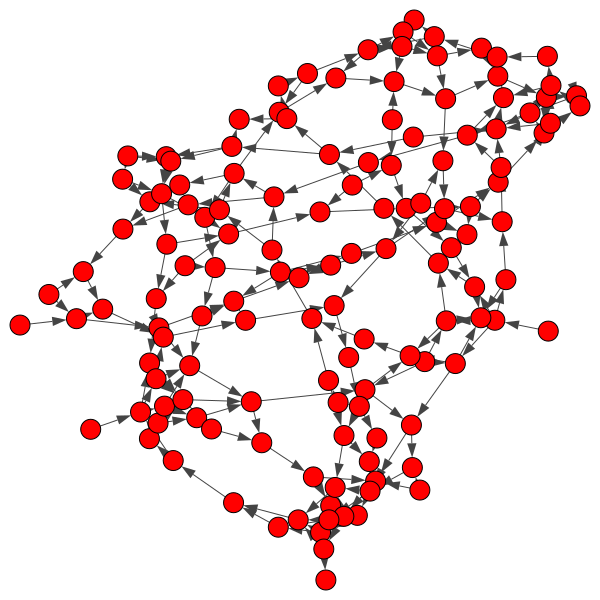

In [57]:
from igraph import plot

plot(example_bb.graph)